## Multiple Linear Regression: King County, WA Housing Analysis

* Student name: Hoang Nguyen, Madoria Thomas, Marcelo Scatena
* Student pace: full time
* Scheduled project review date: 07/01/2021
* Instructor name: Skyler English


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from yellowbrick.features import Rank2D
# from ipynb.fs.full.cleaning_data import clean_data
from geopy import distance
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Split Data into Test and Train

In [4]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [5]:
# We'll use df as our train dataset
y = y_train
X_train['price'] = y
df = X_train.copy()
df_ref = df.copy()

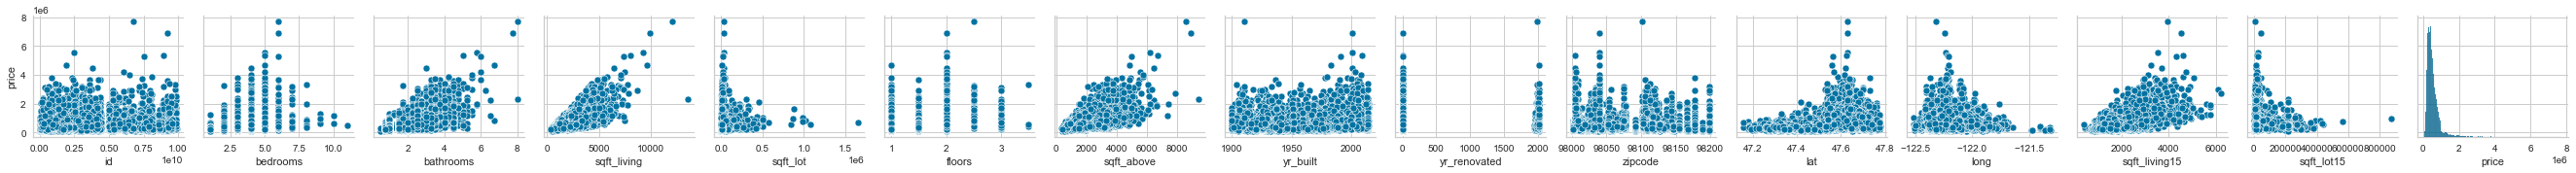

In [6]:
sns.pairplot(df, y_vars=['price'])

The scatter graphs in relation to price shows us the data has a few outliers in the bathrooms, sqft_living, sqft_above, latitude and longitude. It also tells us the data is more clustered around lower priced houses.

In [7]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
6243,9834201100,12/22/2014,4,2.00,1440,4855,2.0,NO,NONE,Good,...,1440,0.0,1972,0.0,98144,47.5717,-122.287,1300,4080,332500.0
8986,7795810110,5/12/2015,3,1.75,1430,9857,1.0,NO,AVERAGE,Good,...,1140,290.0,1980,0.0,98045,47.4964,-121.771,1310,9880,390000.0
9419,1853081250,12/29/2014,4,2.75,3120,5000,2.0,NO,NONE,Average,...,3120,0.0,2010,0.0,98074,47.5940,-122.062,3200,5000,800000.0
10155,2558630350,3/21/2015,4,2.50,2060,6958,1.0,NO,NONE,Average,...,1220,840.0,1974,NaN,98034,47.7251,-122.168,1760,7350,462000.0
10436,3362401000,7/1/2014,3,2.00,2500,4080,1.5,NO,NONE,Very Good,...,1680,820.0,1922,0.0,98103,47.6813,-122.346,1550,3060,695000.0


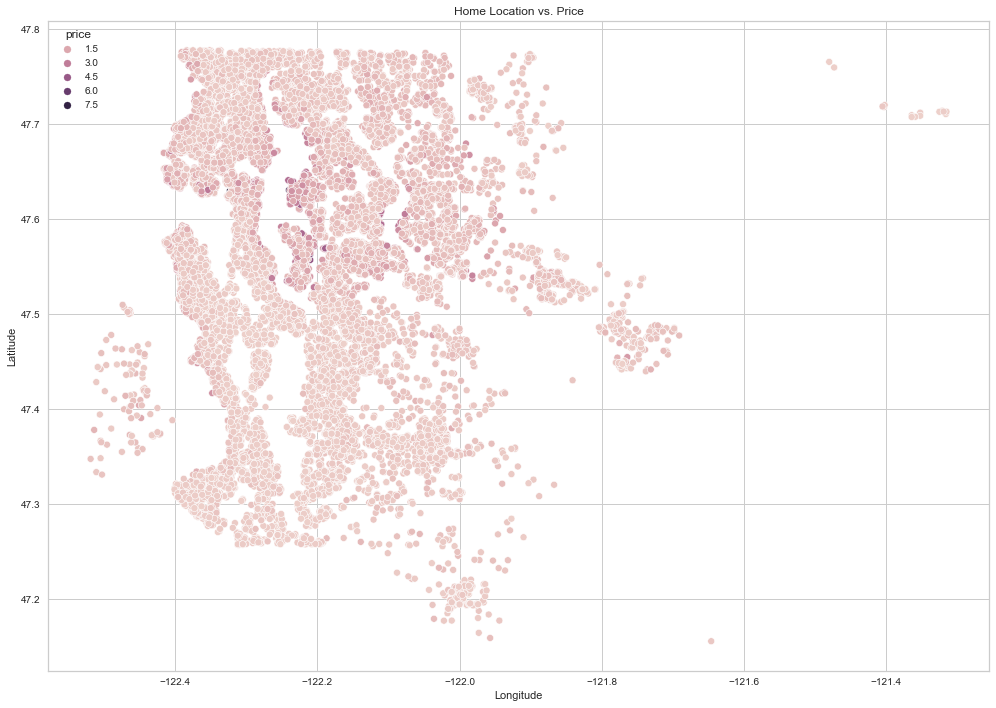

In [8]:
plt.figure(figsize=(14, 10))
plt.title('Home Location vs. Price')
sns.scatterplot(df['long'], df['lat'], hue=df['price'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

We can clearly see the Kings County area in this scatter plot. It's easy to identify as well that the riverside houses tend to be more expensive than houses in other locations.

# Baseline Model

We chose to start with a Baseline model with a simple linear regression that uses sqft_living as it's feature, since it appears to have one of the highest correlation with price amongst the features.

In [9]:
df_inf = df.copy()

In [10]:
def clean_data_model_inf_1(df):
    df = df.filter(['price', 'sqft_living'])
    
    return df

In [11]:
df_inf = clean_data_model_inf_1(df_inf)

In [12]:
X = df_inf.drop('price', axis=1)
y = df_inf['price']
model_inf_1 = sm.OLS(y, sm.add_constant(X)).fit()
model_inf_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 1.676e+04
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:17:30   Log-Likelihood:            -2.4012e+05
No. Observations:               17277   AIC:                         4.802e+05
Df Residuals:                   17275   BIC:                         4.803e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.645e+04   4961.972     -9.361      0.000   -5.62e+04   -3.67e+04
sqft_living   282.2015      2.180    129.476      0.000     277.929     286.474
==============================================================================
Omnibus:                    11495.535   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           371098.388
Skew:                           2.737   Prob(JB):                         0.00
Kurtosis:                      25.035   Cond. No.                     5.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test.copy()
to_clean['price'] = y_test.copy()

# Clean test according to cahnges so far
cleaned_X_test_inf_1 = clean_data_model_inf_1(to_clean)

y_test1 = cleaned_X_test_inf_1['price']
X_test1 = cleaned_X_test_inf_1.drop('price', axis=1)

y_prediction1 =  LR.predict(X_test1)
y_prediction1

rms_inf_1 = mean_squared_error(y_test1, y_prediction1, squared=False)
rms_inf_1

256860.61158460553

In [14]:
r_squared_inf_1 = model_inf_1.rsquared
r_squared_inf_1

0.49249290659878175

In [15]:
LR.score(X_test1, y_test1) #r-squared of test data

0.49332469237979504

This model expalins less than 50% of the variance to the mean. It has an error of $256860.61.

# Model 2 - With no categorical values

In [16]:
df_inf_2 = df_ref.copy()

In [17]:
def clean_data_model_inf_2(df):
    # Drop all categorical data
    df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))
    df.drop(['date', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated'], axis=1, inplace=True)
    
    return df

In [18]:
df_inf_2 = clean_data_model_inf_2(df_inf_2)

In [19]:
X = df_inf_2.drop('price', axis=1)
y = df_inf_2['price']
model_inf_2 = sm.OLS(y, sm.add_constant(X)).fit()
model_inf_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     2516.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:17:30   Log-Likelihood:            -2.3821e+05
No. Observations:               17277   AIC:                         4.764e+05
Df Residuals:                   17266   BIC:                         4.765e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.485e+07   3.49e+06    -15.696      0.000   -6.17e+07    -4.8e+07
id            -1.171e-06   6.29e-07     -1.861      0.063   -2.41e-06    6.24e-08
sqft_living     170.4020     24.787      6.875      0.000     121.817     218.987
sqft_lot          0.2656      0.064      4.165      0.000       0.141       0.391
sqft_above       70.7379     24.850      2.847      0.004      22.030     119.446
sqft_basement    54.7851     24.862      2.204      0.028       6.053     103.517
zipcode        -349.6862     42.153     -8.296      0.000    -432.310    -267.062
lat            6.859e+05   1.36e+04     50.383      0.000    6.59e+05    7.13e+05
long          -4.614e+05   1.64e+04    -28.195      0.000   -4.93e+05   -4.29e+05
sqft_living15    91.7336      4.245     21.607      0.000      83.412     100.055
sqft_lot15       -0.3801      0.096     -3.977      0.000      -0.567      -0.193
==============================================================================
Omnibus:                    13856.401   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           837504.083
Skew:                           3.409   Prob(JB):                         0.00
Kurtosis:                      36.420   Cond. No.                     1.06e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test.copy()
to_clean['price'] = y_test.copy()

# Clean test according to cahnges so far
cleaned_X_test_inf_2 = clean_data_model_inf_2(to_clean)

y_test2 = cleaned_X_test_inf_2['price']
X_test2 = cleaned_X_test_inf_2.drop('price', axis=1)

y_prediction2 =  LR.predict(X_test2)
y_prediction2

rms_inf_2 = mean_squared_error(y_test2, y_prediction2, squared=False)
rms_inf_2

229832.33804559291

In [21]:
r_squared_inf_2 = model_inf_2.rsquared
r_squared_inf_2

0.5930400791406427

In [22]:
LR.score(X_test2, y_test2) #r-squared of test data

0.5943448579125368

This model expalins 59% of the variance to the mean. It has an error of $229832.33.

# Model 3 - With all already cleaned data

In [23]:
df_inf_3 = df_ref.copy()

In [24]:
def clean_data_model_inf_3(df):
    # Drop all columns that need cleaning
    df.drop(['view', 'waterfront', 'yr_renovated', 'grade', 'sqft_basement', 'condition', 'date'], axis=1, inplace=True)
    
    return df

In [25]:
df_inf_3 = clean_data_model_inf_3(df_inf_3)

In [26]:
X = df_inf_3.drop('price', axis=1)
y = df_inf_3['price']
model_inf_3 = sm.OLS(y, sm.add_constant(X)).fit()
model_inf_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2246.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:17:30   Log-Likelihood:            -2.3743e+05
No. Observations:               17277   AIC:                         4.749e+05
Df Residuals:                   17263   BIC:                         4.750e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.066e+07   3.59e+06     -2.970      0.003   -1.77e+07   -3.62e+06
id             -1.24e-06   6.02e-07     -2.061      0.039   -2.42e-06   -6.05e-08
bedrooms      -6.356e+04   2424.766    -26.211      0.000   -6.83e+04   -5.88e+04
bathrooms      6.369e+04   4049.831     15.727      0.000    5.58e+04    7.16e+04
sqft_living     229.5824      5.330     43.072      0.000     219.135     240.030
sqft_lot          0.1631      0.061      2.671      0.008       0.043       0.283
floors         2.967e+04   4465.760      6.645      0.000    2.09e+04    3.84e+04
sqft_above       26.2062      5.329      4.918      0.000      15.761      36.651
yr_built      -2677.2873     80.033    -33.452      0.000   -2834.161   -2520.414
zipcode        -552.7545     40.795    -13.549      0.000    -632.717    -472.792
lat            6.098e+05   1.32e+04     46.221      0.000    5.84e+05    6.36e+05
long          -3.357e+05   1.61e+04    -20.829      0.000   -3.67e+05   -3.04e+05
sqft_living15    91.5414      4.088     22.391      0.000      83.528      99.555
sqft_lot15       -0.4947      0.092     -5.400      0.000      -0.674      -0.315
==============================================================================
Omnibus:                    13525.495   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           771783.234
Skew:                           3.298   Prob(JB):                         0.00
Kurtosis:                      35.072   Cond. No.                     1.14e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test.copy()
to_clean['price'] = y_test.copy()

# Clean test according to cahnges so far
cleaned_X_test_inf_3 = clean_data_model_inf_3(to_clean)

y_test3 = cleaned_X_test_inf_3['price']
X_test3 = cleaned_X_test_inf_3.drop('price', axis=1)

y_prediction3 =  LR.predict(X_test3)
y_prediction3

rms_inf_3 = mean_squared_error(y_test3, y_prediction3, squared=False)
rms_inf_3

222815.15799562552

In [28]:
r_squared_inf_3 = model_inf_3.rsquared
r_squared_inf_3

0.6284809885875513

In [29]:
LR.score(X_test3, y_test3) #r-squared of test data

0.6187374221612001

This model expalins 62% of the variance to the mean. It has an error of $222815.15.

# Model 4 - With all cleaned data minus irrelevant features

In [30]:
df_inf_4 = df_ref.copy()

In [31]:
def clean_data_model_inf_4(df):
    # Fill NaN values with most commom occurances
    df['view'].fillna('NONE', inplace=True)
    df['waterfront'].fillna('NO', inplace=True)
    df['yr_renovated'].fillna(0.0, inplace=True)
    # Convert grade to int
    df['grade'] = df['grade'].apply(lambda x: x[:2] if x[0]=='1' else x[:1]).astype('int64')
    # Remove ? and convert sqft_basement to int
    df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))
    # Change waterfront to numeric
    df['waterfront'] = df['waterfront'].apply(lambda x: 1 if x=='YES' else 0)
    # Change view to numeric
    df['view'] = df['view'].apply(lambda x: 0 if x=='NONE' else (1 if x=='FAIR' else (2 if x=='AVERAGE' else (3 if x=='GOOD' else 4))))
    # Change condition to numeric
    df['condition'] = df['condition'].apply(lambda x: 1 if x=='Poor' else (2 if x=='Fair' else (3 if x=='Average' else (4 if x=='Good' else 5))))

    df.drop(columns=['date', 'id', 'yr_renovated', 'zipcode'], axis=1, inplace=True)
    
    return df

In [32]:
df_inf_4 = clean_data_model_inf_4(df_inf_4)

In [33]:
X = df_inf_4.drop('price', axis=1)
y = df_inf_4['price']
model_inf_4 = sm.OLS(y, sm.add_constant(X)).fit()
model_inf_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2480.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:17:31   Log-Likelihood:            -2.3567e+05
No. Observations:               17277   AIC:                         4.714e+05
Df Residuals:                   17260   BIC:                         4.715e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.534e+07   1.78e+06    -19.900      0.000   -3.88e+07   -3.19e+07
bedrooms      -3.751e+04   2227.428    -16.838      0.000   -4.19e+04   -3.31e+04
bathrooms      4.599e+04   3675.600     12.511      0.000    3.88e+04    5.32e+04
sqft_living      91.4806     21.693      4.217      0.000      48.961     134.000
sqft_lot          0.0947      0.055      1.718      0.086      -0.013       0.203
floors         4169.3551   4044.096      1.031      0.303   -3757.484    1.21e+04
waterfront     6.124e+05   2.04e+04     30.066      0.000    5.72e+05    6.52e+05
view           4.956e+04   2386.844     20.764      0.000    4.49e+04    5.42e+04
condition      3.073e+04   2601.961     11.809      0.000    2.56e+04    3.58e+04
grade          1.005e+05   2436.418     41.264      0.000    9.58e+04    1.05e+05
sqft_above       85.9563     21.632      3.974      0.000      43.556     128.357
sqft_basement    58.2882     21.465      2.716      0.007      16.215     100.362
yr_built      -2658.1179     77.153    -34.453      0.000   -2809.345   -2506.891
lat            5.455e+05   1.18e+04     46.048      0.000    5.22e+05    5.69e+05
long          -1.137e+05   1.34e+04     -8.509      0.000    -1.4e+05   -8.75e+04
sqft_living15    29.7651      3.903      7.627      0.000      22.116      37.415
sqft_lot15       -0.4457      0.083     -5.396      0.000      -0.608      -0.284
==============================================================================
Omnibus:                    14890.470   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1461777.394
Skew:                           3.656   Prob(JB):                         0.00
Kurtosis:                      47.465   Cond. No.                     5.68e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test.copy()
to_clean['price'] = y_test.copy()

# Clean test according to cahnges so far
cleaned_X_test_inf_4 = clean_data_model_inf_4(to_clean)

y_test4 = cleaned_X_test_inf_4['price']
X_test4 = cleaned_X_test_inf_4.drop('price', axis=1)

y_prediction4 =  LR.predict(X_test4)
y_prediction4

rms_inf_4 = mean_squared_error(y_test4, y_prediction4, squared=False)
rms_inf_4

201787.32061842416

In [35]:
r_squared_inf_4 = model_inf_4.rsquared
r_squared_inf_4

0.696875767092322

In [36]:
LR.score(X_test4, y_test4) #r-squared of test data

0.6873039014253686

This model expalins 69% of the variance to the mean. It has an error of $201787.32.

# Checking our Assumptions

## Normality

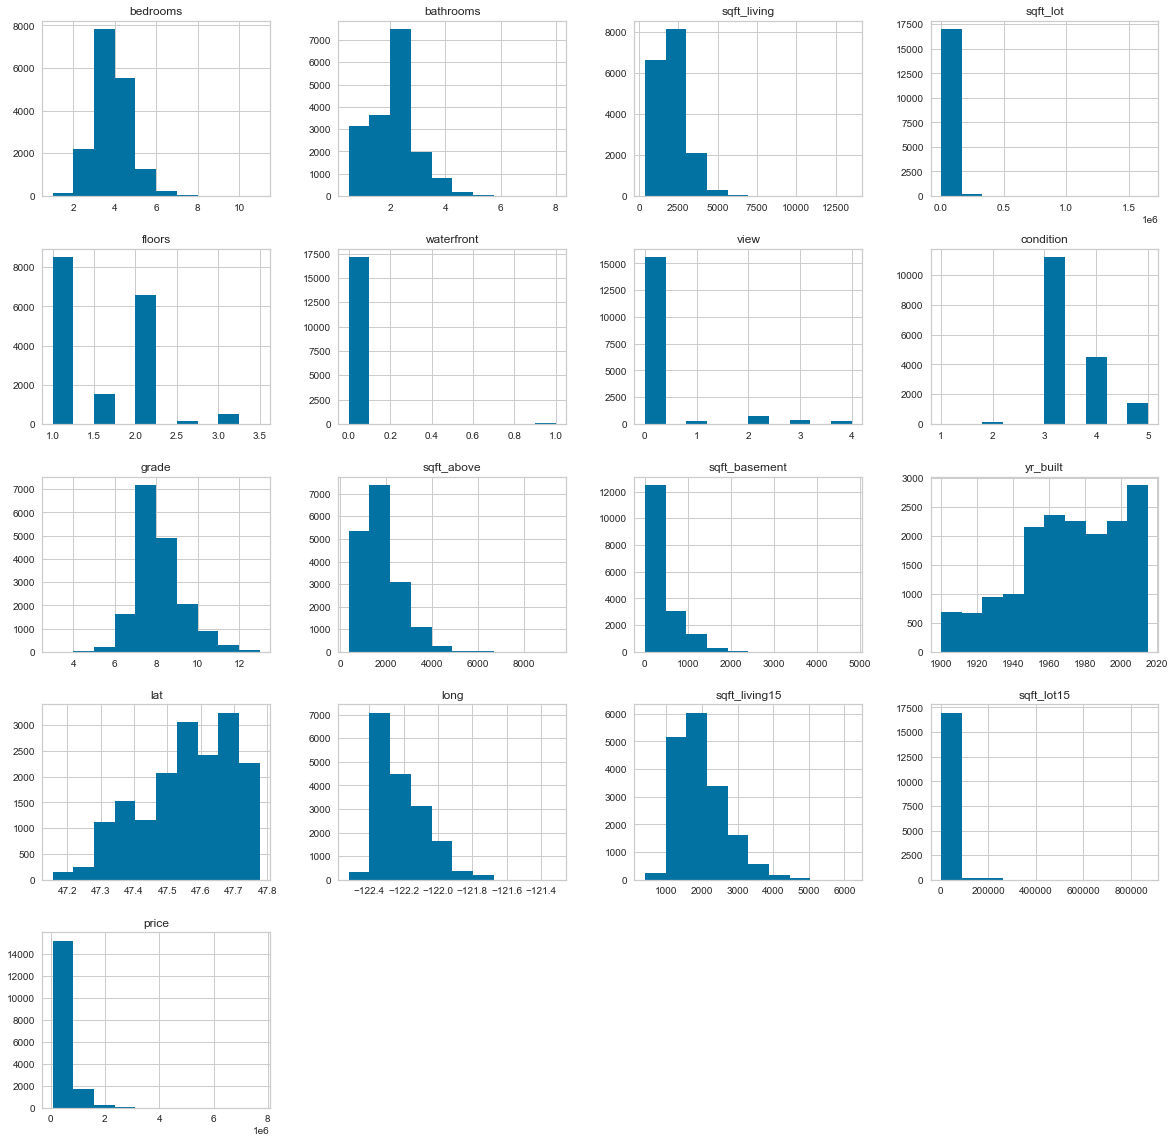

In [37]:
df_inf_4.hist(figsize=(20,20));

None of these variables seem to follow a normal distribution. While this may create problems satisfying all assumptions, we'll first take a look at the other assumptions to see if there are any obvious changes to me made.

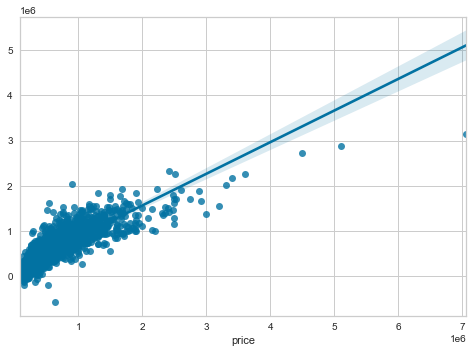

In [38]:
sns.regplot(y_test4, y_prediction4);

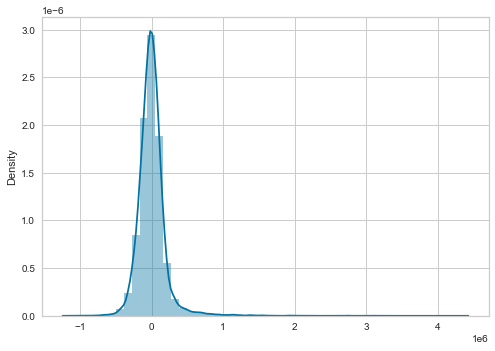

In [39]:
sns.distplot(model_inf_4.resid);

<Figure size 864x576 with 0 Axes>

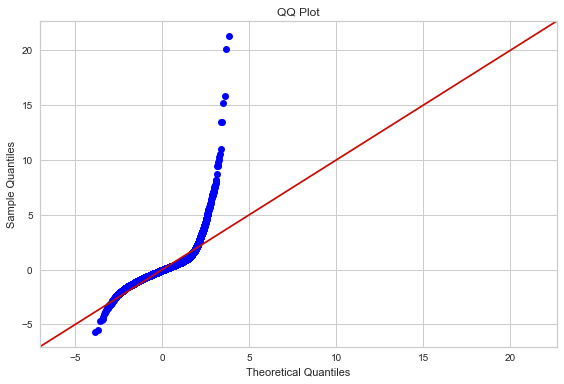

In [40]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model_inf_4.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

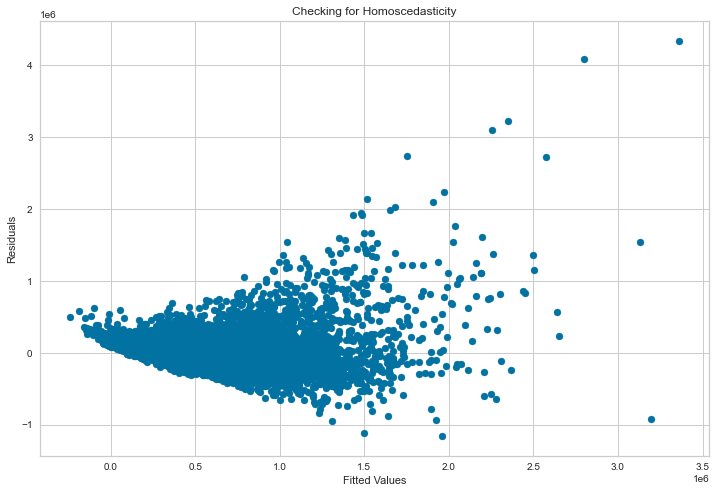

In [41]:
plt.figure(figsize=(12, 8))
plt.scatter(model_inf_4.predict(), model_inf_4.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

Our model so far does not pass the linearity assumption checks.

# Model 5 - Addressing multicolinearity

In [42]:
df_inf_5 = df_inf_4.copy()

We're looking for correlation between features that have an over .7 pearson correlation between them, and we're also looking for features that have a very close to zero correlation with price, which would mean it is not a good price indicator.

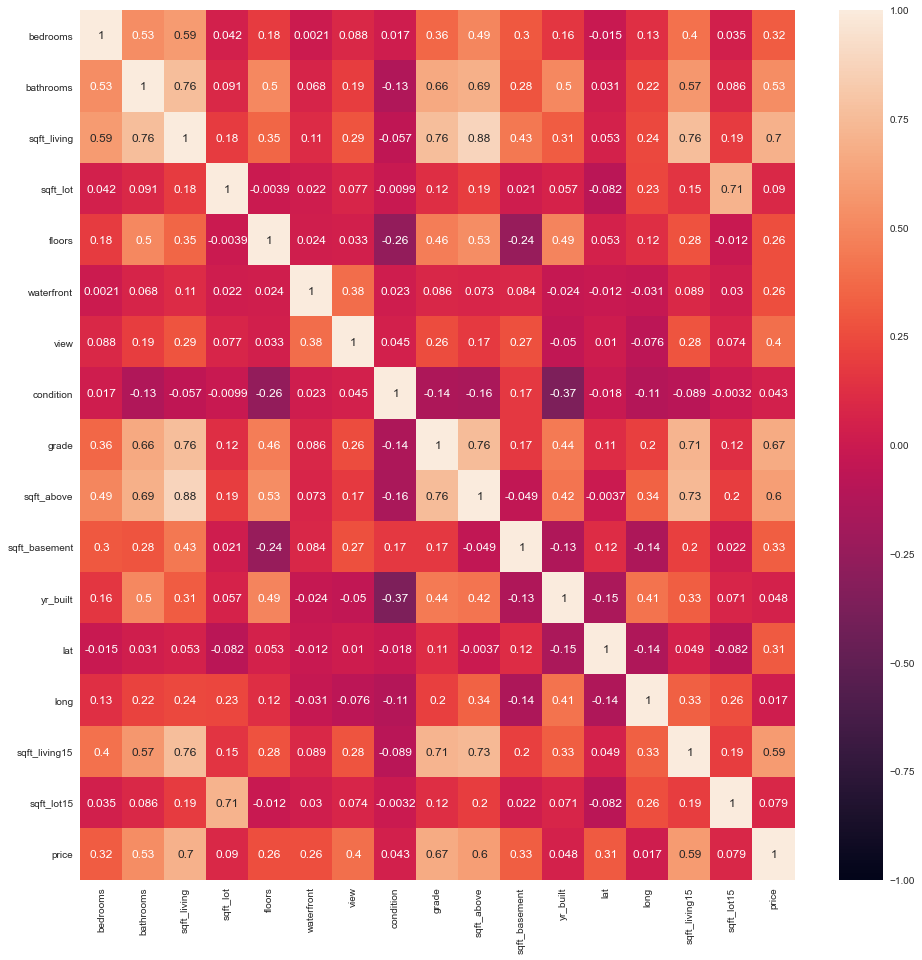

In [43]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df_inf_5.corr(), vmin=-1, vmax=1, annot=True);

''

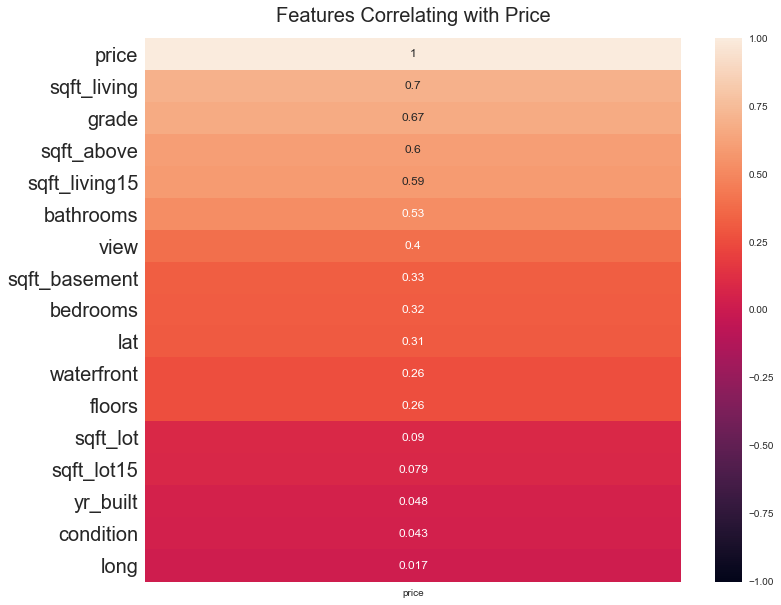

In [44]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df_inf_4.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16)
plt.yticks(fontsize=20)
# plt.savefig('correlation_price_1', bbox_inches='tight')
;

In [45]:
def clean_data_model_inf_5(df):
    # Drop highly correlated features
    df.drop(['grade', 'sqft_above', 'bathrooms', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
    # Drop features uncorrelated with price
    df.drop(['condition', 'sqft_lot'], axis=1, inplace=True)
    return df

In [46]:
df_inf_5 = clean_data_model_inf_5(df_inf_5)

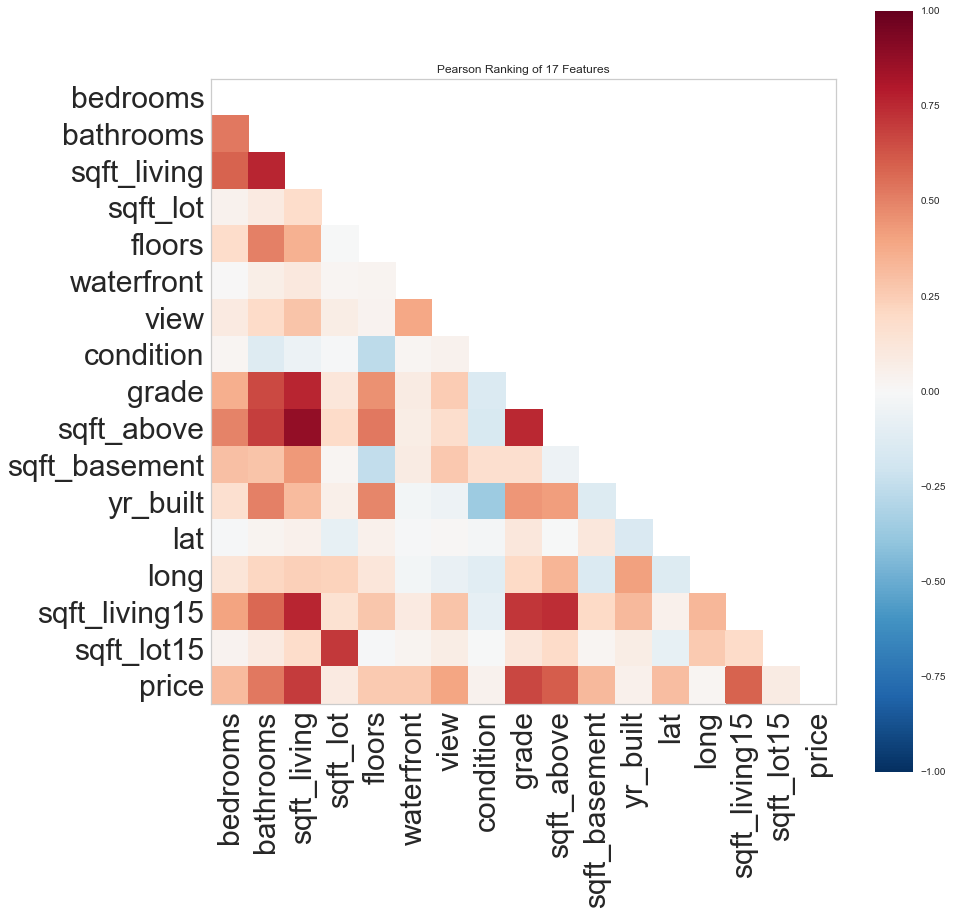

''

In [47]:
fig, ax = plt.subplots(figsize=(14,14))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df_inf_4)
visualizer.show()
# plt.savefig('correlation_1', bbox_inches='tight')
;

In [48]:
X = df_inf_5.drop('price', axis=1)
y = df_inf_5['price']
model_inf_5 = sm.OLS(y, sm.add_constant(X)).fit()
model_inf_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     3578.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:17:39   Log-Likelihood:            -2.3689e+05
No. Observations:               17277   AIC:                         4.738e+05
Df Residuals:                   17267   BIC:                         4.739e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.722e+07   1.79e+06    -26.368      0.000   -5.07e+07   -4.37e+07
bedrooms      -4.403e+04   2308.344    -19.074      0.000   -4.86e+04   -3.95e+04
sqft_living     309.5992      2.911    106.370      0.000     303.894     315.304
floors         2.944e+04   4081.846      7.213      0.000    2.14e+04    3.74e+04
waterfront     5.869e+05   2.18e+04     26.884      0.000    5.44e+05     6.3e+05
view           6.654e+04   2506.808     26.545      0.000    6.16e+04    7.15e+04
sqft_basement   -55.4096      5.017    -11.044      0.000     -65.244     -45.576
yr_built      -1689.5884     72.516    -23.299      0.000   -1831.728   -1547.449
lat            6.393e+05   1.24e+04     51.428      0.000    6.15e+05    6.64e+05
long          -1.648e+05   1.36e+04    -12.110      0.000   -1.91e+05   -1.38e+05
==============================================================================
Omnibus:                    12520.603   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           686013.663
Skew:                           2.926   Prob(JB):                         0.00
Kurtosis:                      33.310   Cond. No.                     3.21e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test4.copy()
to_clean['price'] = y_test4.copy()

# Clean test according to cahnges so far
cleaned_X_test_inf_5 = clean_data_model_inf_5(to_clean)

y_test5 = cleaned_X_test_inf_5['price']
X_test5 = cleaned_X_test_inf_5.drop('price', axis=1)

y_prediction5 =  LR.predict(X_test5)
y_prediction5

rms_inf_5 = mean_squared_error(y_test5, y_prediction5, squared=False)
rms_inf_5

213004.54274662788

In [50]:
r_squared_inf_5 = model_inf_5.rsquared
r_squared_inf_5

0.6509552521258039

In [51]:
LR.score(X_test5, y_test5) #r-squared of test data

0.6515724824024534

This model expalins 65% of the variance to the mean. It has an error of $213004.54.

# MODEL 6 - Dealing with Outliers

In [52]:
df_inf_6 = df_inf_5.copy()

In [53]:
def clean_data_model_inf_6(df):
    # Remove outliers in bedrooms
    df = df[~df['bedrooms'].isin([11, 10, 9])]
    # Fix floors column
    df['floors'] = df['floors'].apply(lambda x: np.ceil(x))
    # Remove outliers in long
    df = df[df['long'] < -121.647]
    # Remove outliers in price
    df = df[df['price'] < 4000000]
    # Remove outliers in sqft_basement
    df = df[df['sqft_basement'] < 3000]
    
    return df

In [54]:
df_inf_6 = clean_data_model_inf_6(df_inf_6)

In [55]:
X = df_inf_6.drop('price', axis=1)
y = df_inf_6['price']
model_inf_6 = sm.OLS(y, sm.add_constant(X)).fit()
model_inf_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     3557.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:17:40   Log-Likelihood:            -2.3556e+05
No. Observations:               17243   AIC:                         4.711e+05
Df Residuals:                   17233   BIC:                         4.712e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.513e+07   1.72e+06    -26.182      0.000   -4.85e+07   -4.18e+07
bedrooms      -3.896e+04   2230.526    -17.465      0.000   -4.33e+04   -3.46e+04
sqft_living     293.3029      2.806    104.521      0.000     287.803     298.803
floors         2.842e+04   3460.173      8.212      0.000    2.16e+04    3.52e+04
waterfront      5.55e+05    2.1e+04     26.382      0.000    5.14e+05    5.96e+05
view           6.988e+04   2393.941     29.189      0.000    6.52e+04    7.46e+04
sqft_basement   -55.7137      4.785    -11.642      0.000     -65.094     -46.334
yr_built      -1554.1497     65.784    -23.625      0.000   -1683.093   -1425.207
lat            6.487e+05   1.18e+04     54.846      0.000    6.25e+05    6.72e+05
long           -1.42e+05   1.32e+04    -10.739      0.000   -1.68e+05   -1.16e+05
==============================================================================
Omnibus:                     9215.947   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           162278.469
Skew:                           2.175   Prob(JB):                         0.00
Kurtosis:                      17.386   Cond. No.                     3.23e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test5.copy()
to_clean['price'] = y_test5.copy()

# Clean test according to cahnges so far
cleaned_X_test_inf_6 = clean_data_model_inf_6(to_clean)

y_test6 = cleaned_X_test_inf_6['price']
X_test6 = cleaned_X_test_inf_6.drop('price', axis=1)

y_prediction6 =  LR.predict(X_test6)
y_prediction6

rms_inf_6 = mean_squared_error(y_test6, y_prediction6, squared=False)
rms_inf_6

201455.89641482546

In [57]:
r_squared_inf_6 = model_inf_6.rsquared
r_squared_inf_6

0.6500366465647276

In [58]:
LR.score(X_test6, y_test6) #r-squared of test data

0.6358583516136871

This model expalins 65% of the variance to the mean. It has an error of $201455.89.

## MODEL 7 - Feature Engineering

In [59]:
df_inf_7 = df_inf_6.copy()

In [60]:
def distance_from(lat, long, series_lat, series_long):
    lat_long = series_lat.astype(str) + ',' + series_long.astype(str)
    lat_long = list(map(eval, lat_long))
    coordinates = (lat, long)
    miles = []
    for i in lat_long:
        miles.append(round(distance.distance(i, coordinates).miles, 1))
    return miles

In [61]:
def clean_data_model_inf_7(df):
    df['distance_seattle'] = distance_from(47.6062, -122.3321, df['lat'], df['long'])
    df['distance_redmond'] = distance_from(47.6740, -122.1215, df['lat'], df['long'])
    df['distance_kent'] = distance_from(47.3809, -122.2348, df['lat'], df['long'])
    
    df.drop(['lat', 'long'], axis=1, inplace=True)
    # Create column with rencent builds
    df['recent_build'] = df['yr_built'].apply(lambda x: 1 if x > 2005 else 0)
    df.drop(['yr_built'], axis=1, inplace=True)
    
    return df

In [62]:
df_inf_7 = clean_data_model_inf_7(df_inf_7)

In [63]:
X = df_inf_7.drop('price', axis=1)
y = df_inf_7['price']
model_inf_7 = sm.OLS(y, sm.add_constant(X)).fit()
model_inf_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3844.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:17:55   Log-Likelihood:            -2.3450e+05
No. Observations:               17243   AIC:                         4.690e+05
Df Residuals:                   17232   BIC:                         4.691e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              1.97e+05   1.03e+04     19.068      0.000    1.77e+05    2.17e+05
bedrooms         -3.376e+04   2104.509    -16.042      0.000   -3.79e+04   -2.96e+04
sqft_living        294.2561      2.648    111.132      0.000     289.066     299.446
floors           -1.691e+04   3407.234     -4.962      0.000   -2.36e+04   -1.02e+04
waterfront         5.81e+05   1.98e+04     29.341      0.000    5.42e+05     6.2e+05
view              6.922e+04   2261.555     30.609      0.000    6.48e+04    7.37e+04
sqft_basement      -88.6742      4.587    -19.331      0.000     -97.666     -79.683
distance_seattle -1.643e+04    329.164    -49.901      0.000   -1.71e+04   -1.58e+04
distance_redmond -2145.3794    380.487     -5.639      0.000   -2891.173   -1399.585
distance_kent     5983.7412    289.351     20.680      0.000    5416.583    6550.899
recent_build     -6819.2659   4869.302     -1.400      0.161   -1.64e+04    2725.061
==============================================================================
Omnibus:                     9558.735   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           184714.516
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      18.386   Cond. No.                     3.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test6.copy()
to_clean['price'] = y_test6.copy()

# Clean test according to cahnges so far
cleaned_X_test_inf_7 = clean_data_model_inf_7(to_clean)

y_test7 = cleaned_X_test_inf_7['price']
X_test7 = cleaned_X_test_inf_7.drop('price', axis=1)

y_prediction7 =  LR.predict(X_test7)
y_prediction7

rms_inf_7 = mean_squared_error(y_test7, y_prediction7, squared=False)
rms_inf_7

188781.48495303158

In [65]:
r_squared_inf_7 = model_inf_7.rsquared
r_squared_inf_7

0.6904517256259577

In [66]:
LR.score(X_test7, y_test7) #r-squared of test data

0.6802362833647551

This model expalins 65% of the variance to the mean. It has an error of $201455.89.

## MODEL 8 - More Engineering

In [68]:
df_inf_8 = df_inf_7.copy()

In [69]:
def clean_data_model_inf_8(df):
    #Engineer two more features
    df['area'] = df['bedrooms'] * df['sqft_living'] * df['sqft_basement']
    df['multi_dist'] = df['distance_seattle'] * df['distance_redmond']
    
    #Drop insignificant feature
    df.drop(['recent_build', 'floors'], axis=1, inplace=True)
    return df

In [70]:
df_inf_8 = clean_data_model_inf_8(df_inf_8)

In [71]:
X = df_inf_8.drop('price', axis=1)
y = df_inf_8['price']
model_inf_8 = sm.OLS(y, sm.add_constant(X)).fit()
model_inf_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     4513.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:18:17   Log-Likelihood:            -2.3352e+05
No. Observations:               17243   AIC:                         4.671e+05
Df Residuals:                   17232   BIC:                         4.672e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             6.416e+05   1.38e+04     46.417      0.000    6.14e+05    6.69e+05
bedrooms         -4.146e+04   1999.018    -20.740      0.000   -4.54e+04   -3.75e+04
sqft_living        276.2119      2.312    119.489      0.000     271.681     280.743
waterfront        5.977e+05   1.87e+04     31.942      0.000    5.61e+05    6.34e+05
view              6.588e+04   2136.240     30.838      0.000    6.17e+04    7.01e+04
sqft_basement     -162.2801      6.238    -26.016      0.000    -174.507    -150.054
distance_seattle -3.934e+04    627.799    -62.659      0.000   -4.06e+04   -3.81e+04
distance_redmond -3.006e+04    735.651    -40.861      0.000   -3.15e+04   -2.86e+04
distance_kent     2414.3207    281.666      8.572      0.000    1862.226    2966.415
area                 0.0072      0.000     16.409      0.000       0.006       0.008
multi_dist        1545.3060     36.319     42.548      0.000    1474.117    1616.495
==============================================================================
Omnibus:                     8709.317   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           174120.632
Skew:                           1.970   Prob(JB):                         0.00
Kurtosis:                      18.061   Cond. No.                     9.84e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test7.copy()
to_clean['price'] = y_test7.copy()

# Clean test according to cahnges so far
cleaned_X_test_inf_8 = clean_data_model_inf_8(to_clean)

y_test8 = cleaned_X_test_inf_8['price']
X_test8 = cleaned_X_test_inf_8.drop('price', axis=1)

y_prediction8 =  LR.predict(X_test8)
y_prediction8

rms_inf_8 = mean_squared_error(y_test8, y_prediction8, squared=False)
rms_inf_8

179322.0176955899

In [73]:
r_squared_inf_8 = model_inf_8.rsquared
r_squared_inf_8

0.7236678361681808

In [74]:
LR.score(X_test8, y_test8) #r-squared of test data

0.711478872354308

In [75]:
# features = np.array([bedrooms, sqft_living, floors, waterfront, view, sqft_basement, distance_seattle, distance_redmond, distance_kent, area, multi_dist], dtype=float)

values = [1, 123, 0, 0, 0, 1, 12, 5]

def values_formula(values):
    features = []
    for value in values:
        features.append(value)
    features.append(features[0]*features[1]*features[5])
    features.append(features[6]*features[7])
    return features

features = values_formula(values)

formula = LR.intercept_ + (np.dot(LR.coef_, features))
formula

338807.7401400725

In [76]:
model_coefficients = pd.DataFrame(model_inf_8.params[1:], columns=['coefficients'])
print("Final Regression Formula\n")
print(LR.intercept_, '+')
print('sum(')
for i in range(len(model_coefficients)):
    print(model_coefficients.coefficients[i], '*', model_coefficients.index[i])
print(')')


Final Regression Formula

641550.6279671564 +
sum(
-41459.388746024815 * bedrooms
276.2119257871186 * sqft_living
597661.6293493407 * waterfront
65876.82002878952 * view
-162.2801433110315 * sqft_basement
-39337.3253582741 * distance_seattle
-30059.257355275466 * distance_redmond
2414.320739894132 * distance_kent
0.007177473965142787 * area
1545.3060191958073 * multi_dist
)


# Reassessing Linear Regression Assumptions

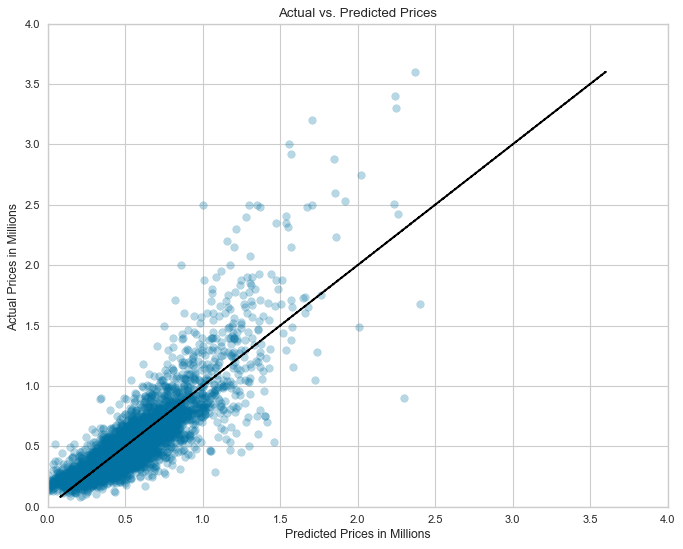

In [77]:
y_prediction_transformed = y_prediction8/1000000
y_test_transformed = y_test8/1000000
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(y_prediction_transformed, y_test_transformed, alpha = .28)
plt.plot(y_test_transformed,y_test_transformed, linestyle = "dashed", color = "black")
plt.xlabel("Predicted Prices in Millions")
plt.ylabel("Actual Prices in Millions ")
plt.title ("Actual vs. Predicted Prices")
plt.xlim([0, 4])
plt.ylim([0, 4]);

# plt.savefig('my_graph', bbox_inches='tight')

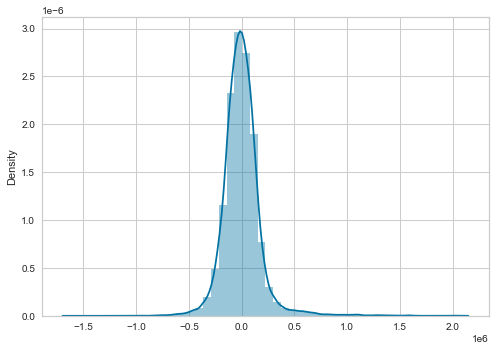

In [78]:
sns.distplot(model_inf_8.resid);

<Figure size 864x576 with 0 Axes>

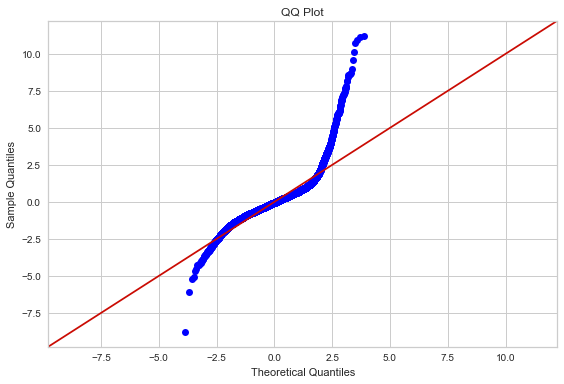

In [79]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model_inf_8.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

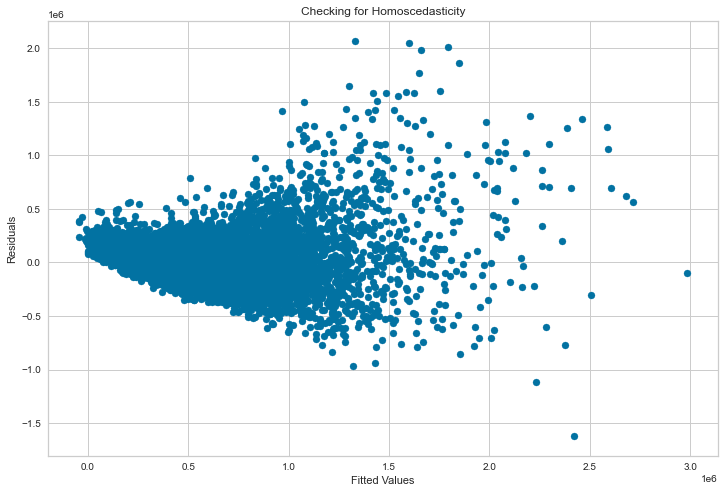

In [80]:
plt.figure(figsize=(12, 8))
plt.scatter(model_inf_8.predict(), model_inf_8.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

The assumptions look better than the baseline model one, but some transformations are needed to make the model more linear.

## MODEL 9 -  Log Transformations

In [81]:
df_pred_1 = df_inf_8.copy()

In [82]:
def clean_data_model_pred_1(df, df2):
    #Adding our continue variables back
    df['sqft_above'] = df2['sqft_above']
    df['sqft_living15'] = df2['sqft_living15']
    df['sqft_lot'] = df2['sqft_lot']
    
    #Accounting for log(0) scenarios
    df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 1 if x==0 else x)
    df['sqft_living15'] = df['sqft_living15'].apply(lambda x: 1 if x==0 else x)
    df['sqft_above'] = df['sqft_above'].apply(lambda x: 1 if x==0 else x)
    df['sqft_lot'] = df['sqft_lot'].apply(lambda x: 1 if x==0 else x)
    
    #Applying log transformation to variables
    df['log_sqft_living'] = np.log(df['sqft_living'])
    df['log_sqft_basement'] = np.log(df['sqft_basement'])
    df['log_sqft_above'] = np.log(df['sqft_above'])
    df['log_sqft_living15'] = np.log(df['sqft_living15'])
    df['log_sqft_lot'] = np.log(df['sqft_lot'])
    
    # Drop columns that become insignificant after log cahnge
    df.drop(['sqft_above', 'sqft_lot'], axis=1, inplace=True)
    
    return df

In [83]:
df_pred_1 = clean_data_model_pred_1(df_pred_1, df_inf_4)

In [84]:
X = df_pred_1.drop('price', axis=1)
y = df_pred_1['price']
model_pred_1 = sm.OLS(y, sm.add_constant(X)).fit()
model_pred_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     3102.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:18:49   Log-Likelihood:            -2.3292e+05
No. Observations:               17243   AIC:                         4.659e+05
Df Residuals:                   17226   BIC:                         4.660e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.568e+06   1.41e+05     18.232      0.000    2.29e+06    2.84e+06
bedrooms          -2.143e+04   2154.209     -9.948      0.000   -2.57e+04   -1.72e+04
sqft_living         300.7362      8.196     36.691      0.000     284.670     316.802
waterfront         6.103e+05   1.81e+04     33.717      0.000    5.75e+05    6.46e+05
view               5.293e+04   2112.076     25.059      0.000    4.88e+04    5.71e+04
sqft_basement       -53.0597     18.276     -2.903      0.004     -88.883     -17.237
distance_seattle  -4.163e+04    637.842    -65.268      0.000   -4.29e+04   -4.04e+04
distance_redmond  -2.737e+04    723.434    -37.836      0.000   -2.88e+04    -2.6e+04
distance_kent      3397.6390    275.858     12.317      0.000    2856.929    3938.349
area                  0.0022      0.001      3.323      0.001       0.001       0.003
multi_dist         1538.9883     35.274     43.630      0.000    1469.848    1608.129
sqft_living15       153.5795     11.468     13.392      0.000     131.101     176.058
log_sqft_living   -3.896e+05   2.75e+04    -14.142      0.000   -4.44e+05   -3.36e+05
log_sqft_basement  1.012e+04   1119.147      9.046      0.000    7930.056    1.23e+04
log_sqft_above     2.003e+05   2.21e+04      9.081      0.000    1.57e+05    2.44e+05
log_sqft_living15 -1.515e+05   2.34e+04     -6.483      0.000   -1.97e+05   -1.06e+05
log_sqft_lot       2.142e+04   1839.645     11.642      0.000    1.78e+04     2.5e+04
==============================================================================
Omnibus:                     8592.323   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           170230.509
Skew:                           1.937   Prob(JB):                         0.00
Kurtosis:                      17.898   Cond. No.                     7.72e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.72e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test8.copy()
to_clean['price'] = y_test8.copy()

# Clean test according to cahnges so far
cleaned_X_test_pred_1 = clean_data_model_pred_1(to_clean, cleaned_X_test_inf_4)

y_test9 = cleaned_X_test_pred_1['price']
X_test9 = cleaned_X_test_pred_1.drop('price', axis=1)

y_prediction9 =  LR.predict(X_test9)
y_prediction9

rms_pred_1 = mean_squared_error(y_test9, y_prediction9, squared=False)
rms_pred_1

173405.0952569999

In [86]:
r_squared_pred_1 = model_pred_1.rsquared
r_squared_pred_1

0.7423423673359115

In [87]:
LR.score(X_test9, y_test9) #r-squared of test data

0.7302048761634439

## MODEL 10 - Transformations

In [88]:
df_pred_2 = df_inf_8.copy()

In [89]:
def clean_data_model_pred_2(df):

    # Normalizing the whole dataframe
    d = preprocessing.normalize(df)
    df = pd.DataFrame(d, columns=df.keys())
    
    # Drop columns that become insignificant after normalization
    df.drop(['waterfront', 'bedrooms', 'distance_redmond'], axis=1, inplace=True)
    
    return df

In [90]:
df_pred_2 = clean_data_model_pred_2(df_pred_2)

In [91]:
X = df_pred_2.drop('price', axis=1)
y = df_pred_2['price']
model_pred_2 = sm.OLS(y, sm.add_constant(X)).fit()
model_pred_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.760e+05
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:18:57   Log-Likelihood:                 27415.
No. Observations:               17243   AIC:                        -5.481e+04
Df Residuals:                   17235   BIC:                        -5.475e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9777      0.002    556.342      0.000       0.974       0.981
sqft_living          5.5482      0.394     14.067      0.000       4.775       6.321
view              2613.1964    473.899      5.514      0.000    1684.307    3542.086
sqft_basement      883.1680      7.399    119.362      0.000     868.665     897.671
distance_seattle  -589.9007     60.937     -9.681      0.000    -709.343    -470.458
distance_kent      404.9488     26.144     15.489      0.000     353.705     456.193
area                -0.9835      0.002   -457.082      0.000      -0.988      -0.979
multi_dist          10.1666      1.950      5.212      0.000       6.344      13.990
==============================================================================
Omnibus:                     8660.847   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           104696.074
Skew:                           2.127   Prob(JB):                         0.00
Kurtosis:                      14.298   Cond. No.                     1.36e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test8.copy()
to_clean['price'] = y_test8.copy()

# Clean test according to cahnges so far
cleaned_X_test_pred_2 = clean_data_model_pred_2(to_clean)

y_test10 = cleaned_X_test_pred_2['price']
X_test10 = cleaned_X_test_pred_2.drop('price', axis=1)

y_prediction10 =  LR.predict(X_test10)
y_prediction10

rms_pred_2 = mean_squared_error(y_test10, y_prediction10, squared=False)
rms_pred_2

0.047971078166597306

In [93]:
r_squared_pred_2 = model_pred_2.rsquared
r_squared_pred_2

0.9862062274845598

In [94]:
LR.score(X_test10, y_test10) #r-squared of test data

0.9867222419576921

# Visualizations for Presentation

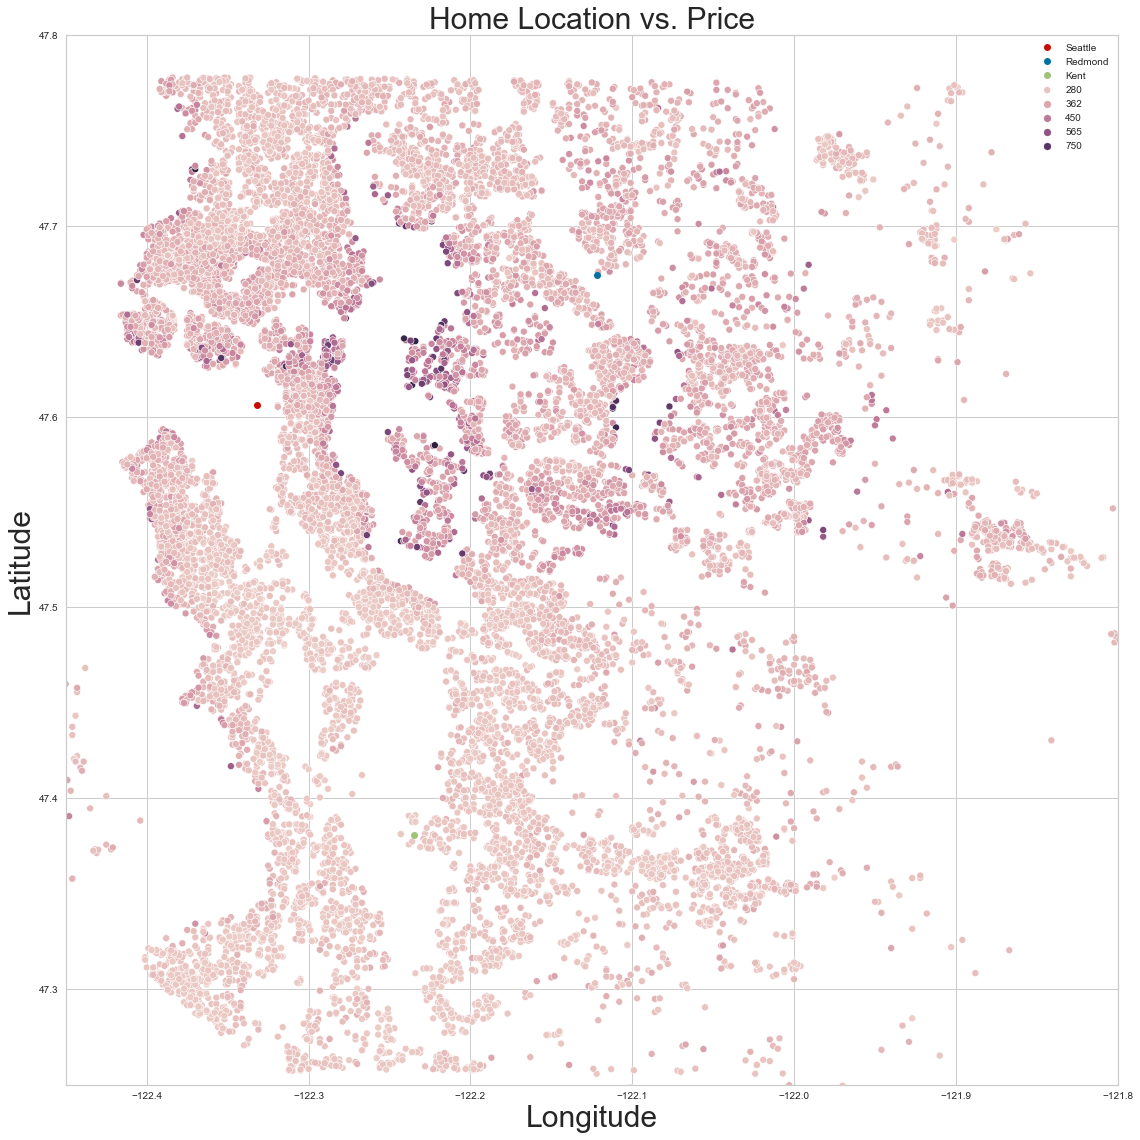

In [95]:
fig, ax = plt.subplots(figsize=(16, 16))
plt.title('Home Location vs. Price', fontsize=30)
sns.scatterplot(df_inf_6['long'], df_inf_6['lat'], hue=df_inf_6['price'])

plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)
plt.legend([280,362,450,565,750,1000])
ax.plot(-122.3321, 47.6062, 'ro')
ax.plot(-122.1215, 47.6740, 'bo')
ax.plot(-122.2348, 47.3809, 'go')
ax.set_xlim(-122.45, -121.80)
ax.set_ylim(47.25, 47.80)
plt.legend(['Seattle', 'Redmond', 'Kent', 280,362,450,565,750,1000])
# plt.savefig('loc_price_2', bbox_inches='tight')
plt.tight_layout();

<Figure size 576x396 with 0 Axes>

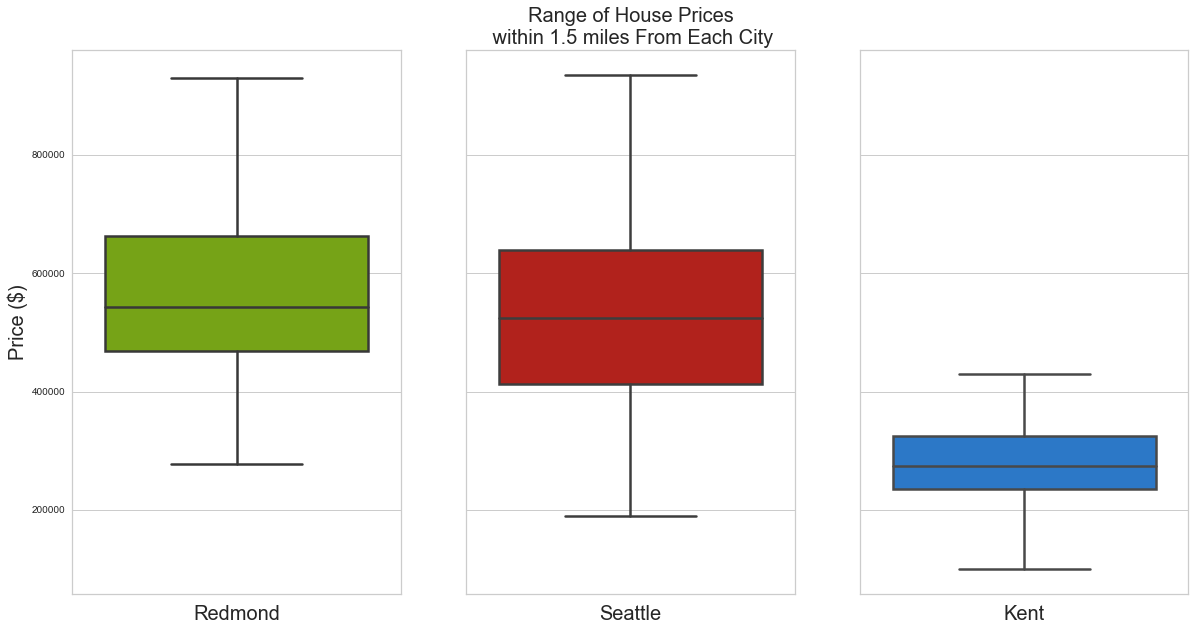

In [96]:
dist_kent = df_inf_8[df_inf_8['distance_kent'] <= 1.5].sort_values(by='price', ascending=False)
dist_redmond = df_inf_8[df_inf_8['distance_redmond'] <= 1.5].sort_values(by='price', ascending=False)
dist_seattle = df_inf_8[df_inf_8['distance_seattle'] <= 1.5].sort_values(by='price', ascending=False)

fig = plt.figure()
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey=True, figsize=(20,10), squeeze=False)

sns.boxplot(y="price", data=dist_redmond, ax=axes[0][0], linewidth=2.5, color="#7FBA00", showfliers=False)
sns.boxplot(y="price", data=dist_seattle, ax=axes[0][1], linewidth=2.5, color="r", showfliers=False)
sns.boxplot(y="price", data=dist_kent, ax=axes[0][2], linewidth=2.5, color="#1277e1", showfliers=False)

axes[0][0].set_ylabel('Price ($)', fontsize=20)
axes[0][1].set_ylabel('')
axes[0][2].set_ylabel('')
axes[0][0].set_xlabel('Redmond', fontsize=20)
axes[0][1].set_xlabel('Seattle', fontsize=20)
axes[0][2].set_xlabel('Kent', fontsize=20)
axes[0][1].set_title('Range of House Prices\n within 1.5 miles From Each City', fontsize=20);

# plt.savefig('price_dist_1', bbox_inches='tight');

''

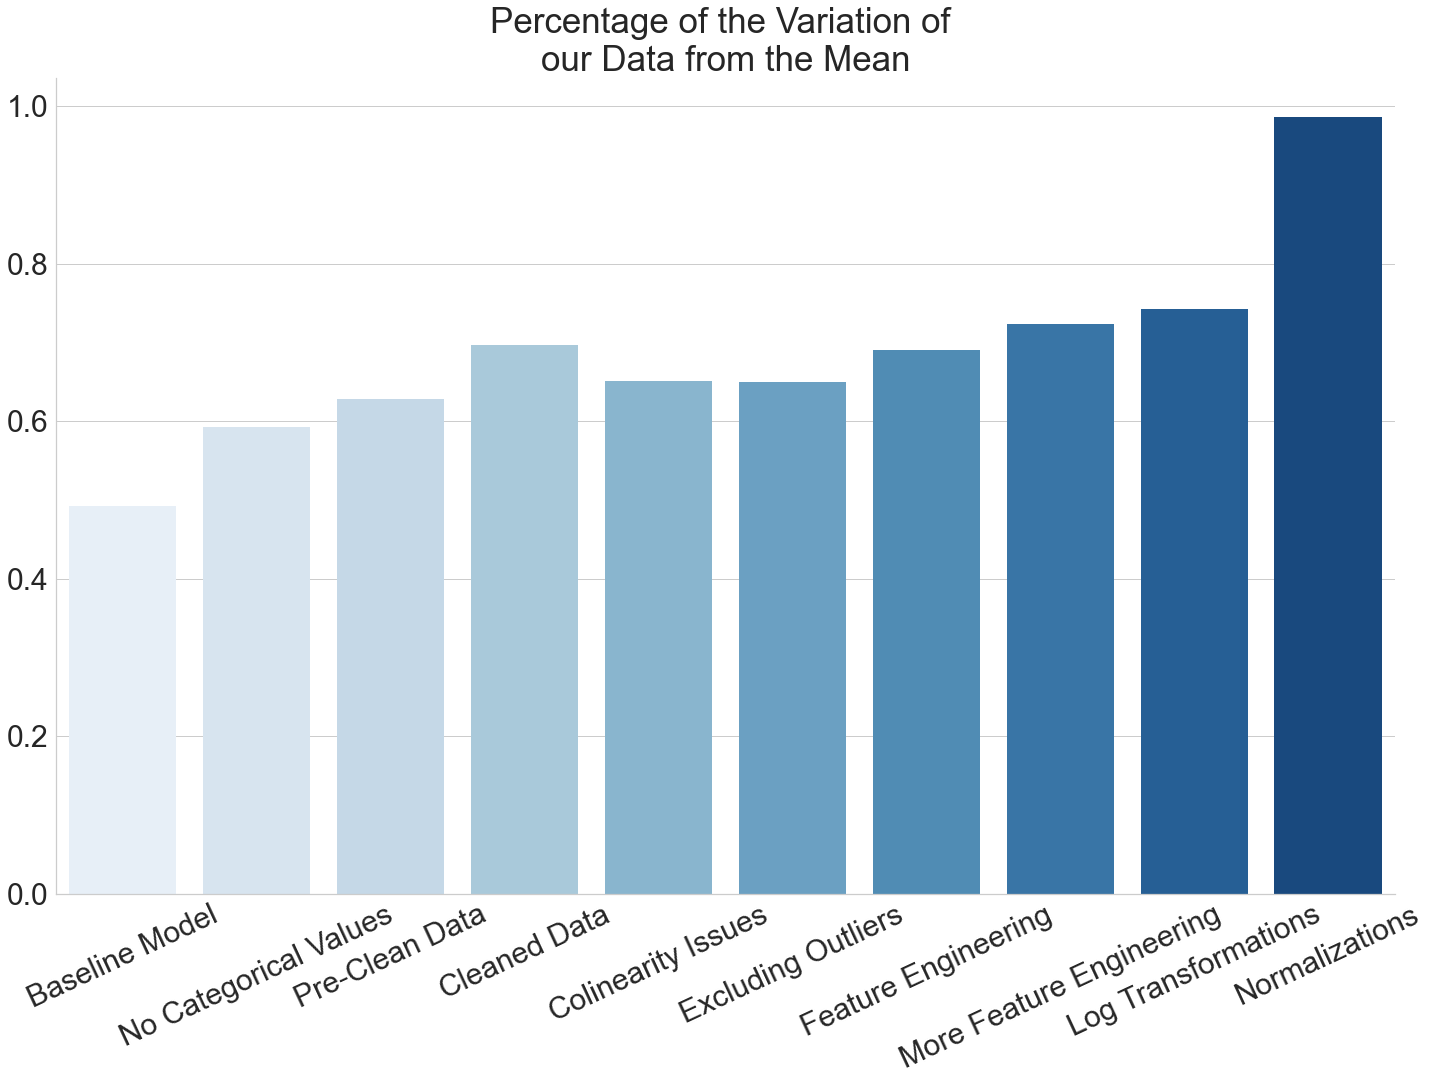

In [97]:
r_squares = [r_squared_inf_1, r_squared_inf_2, r_squared_inf_3, r_squared_inf_4, r_squared_inf_5, r_squared_inf_6, r_squared_inf_7, r_squared_inf_8, r_squared_pred_1, r_squared_pred_2]

fig, ax = plt.subplots(figsize=(24, 15))
x_label = ['Baseline Model', 'No Categorical Values','Pre-Clean Data', 'Cleaned Data', 'Colinearity Issues', 'Excluding Outliers', 'Feature Engineering','More Feature Engineering', 'Log Transformations', 'Normalizations']

ax = sns.barplot(x_label, r_squares, palette="Blues")
plt.xticks(rotation=25, size=30)
plt.yticks(size=30)
sns.despine()

ax.set_title('Percentage of the Variation of \nour Data from the Mean', fontsize=35)
# ax.set_xlabel('Model Number', fontsize=35)

# plt.savefig('r_squared_1', bbox_inches='tight');
;

''

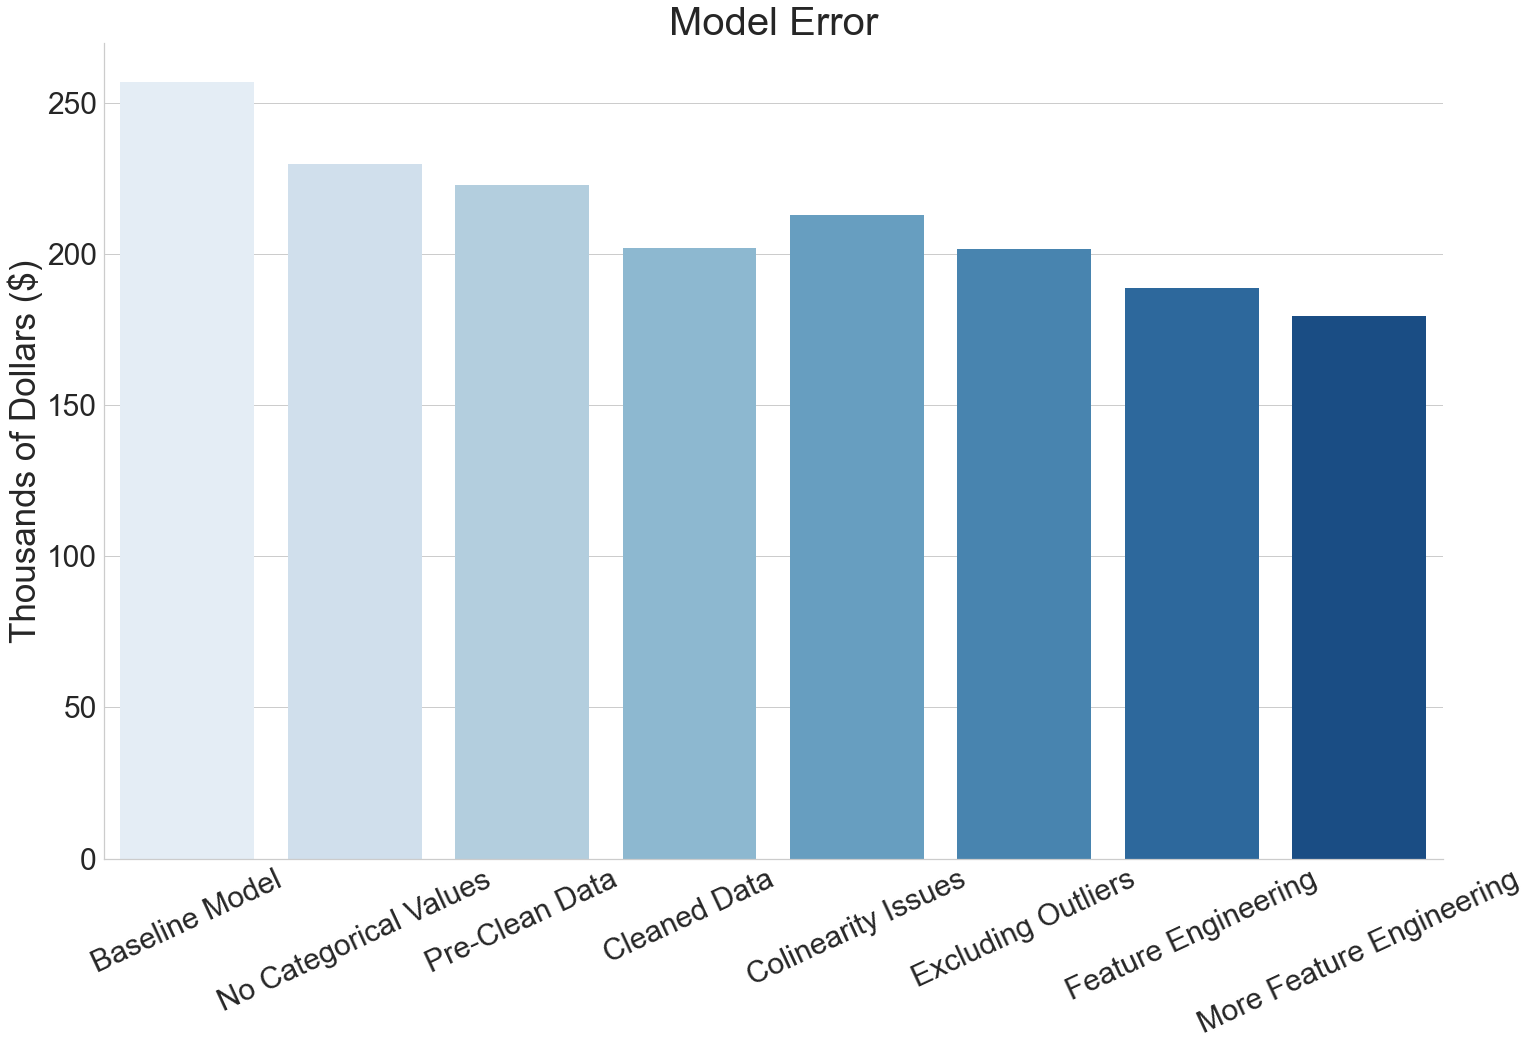

In [98]:
rms_lst = [rms_inf_1, rms_inf_2, rms_inf_3, rms_inf_4, rms_inf_5, rms_inf_6, rms_inf_7, rms_inf_8]
for i in range(len(rms_lst)):
    rms_lst[i] /= 1000

fig, ax = plt.subplots(figsize=(24, 15))
x_label = ['Baseline Model', 'No Categorical Values','Pre-Clean Data', 'Cleaned Data', 'Colinearity Issues', 'Excluding Outliers', 'Feature Engineering','More Feature Engineering']

ax = sns.barplot(x_label, rms_lst, palette="Blues")
ax.set_ylabel('Thousands of Dollars ($)', fontsize=35)

plt.xticks(rotation=25, size=30)
plt.yticks(size=30)
sns.despine()

ax.set_title('Model Error', fontsize=40)

# plt.savefig('rmse_1', bbox_inches='tight')
;